In [3]:
#!git clone https://github.com/CSSEGISandData/COVID-19.git
!cd COVID-19
!git pull

Already up to date.


In [349]:
import glob
import os
import pandas as pd
import numpy as np
from datetime import datetime

In [41]:
result = {}

In [243]:
for fn in glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/**.csv'):
    dt = pd.to_datetime(os.path.basename(fn)[:-4])
    if dt < pd.Timestamp('2020-03-22'):
        # Old format
        df = pd.read_csv(fn, parse_dates=True).drop(columns='Province/State').groupby(by='Country/Region').sum()
        if 'Latitude' in df: 
            del df['Latitude']
        if 'Longitude' in df:
            del df['Longitude']
    else:
        df = pd.read_csv(fn).drop(columns=['FIPS', 'Admin2', 'Province_State', 'Lat', 'Long_', 'Combined_Key', 'Active']).groupby(by='Country_Region').sum()
        
        
    result[dt] = df

In [244]:
df = pd.concat(result).reorder_levels([1, 0]).sort_index()

In [325]:
def change_since_100(cdf):
    

    days_since_100_idx = (cdf.index - cdf.index[cdf['Confirmed'] > 100][0]).astype('timedelta64[D]')

    change_since_100 = cdf['Confirmed'] #- cdf['Confirmed'][days_since_100_idx == 0][0]
    change_since_100.index = days_since_100_idx
    change_since_100 = change_since_100.loc[0:]
    
    change_since_100[change_since_100 < 0] = np.nan

    #change_since_100.plot(logy=True, label=country);
    return change_since_100

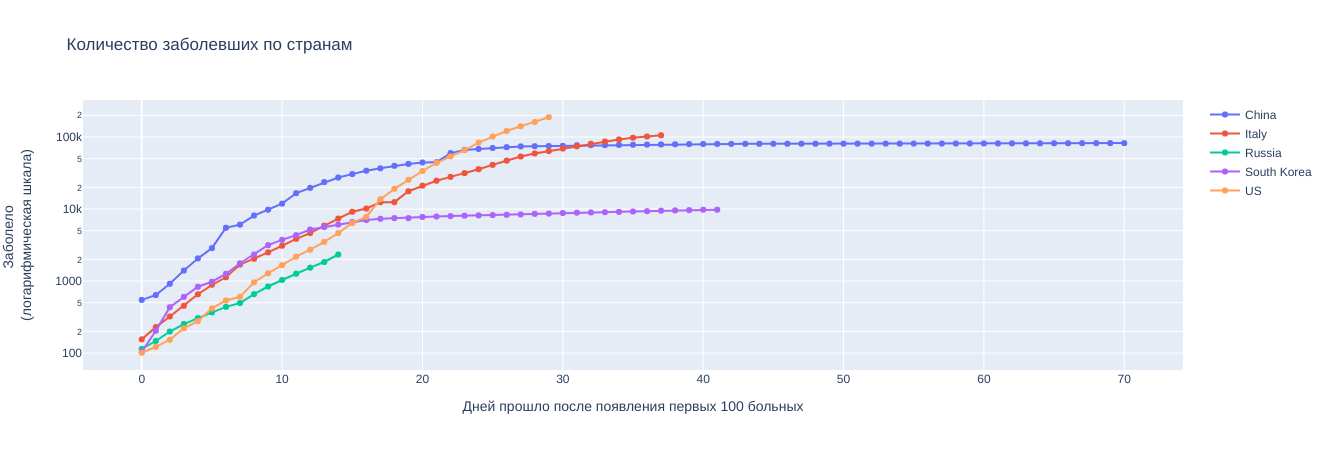

In [373]:
# Create traces
import plotly.graph_objects as go
fig = go.Figure()

cdf_result = {}

include_plot = sorted(['Russia', 'US', 'Italy', 'China', 'South Korea'])
dt_index = pd.date_range(start='2020-01-22', end=datetime.now().date())

for country in sorted(list(set(df.index.get_level_values(0)))):
    if country == 'South Korea':
        cdf = pd.concat([df.loc['South Korea', :], df.loc["Korea, South",:]])
        cdf = cdf.reindex(dt_index).ffill()
    elif country == 'China':
        _cdf = df.loc['Mainland China'].loc[:'2020-03-10']
        cdf = pd.concat([_cdf, df.loc["China",:]])
        cdf = cdf.reindex(dt_index).ffill()
    elif country in {"Korea, South", 'Mainland China'}:
        continue
    else:
        cdf = df.loc[country,:]
        
    if len(cdf) == 0 or (cdf['Confirmed'][-1] < 100 and country != 'Mainland China'):
        continue
        
    # Calc cases since first 100 
    chg = change_since_100(cdf)
    cdf_result[country] = chg
    
    if country in include_plot:
        fig.add_trace(go.Scatter(x=chg.index, y=chg.values,
                        mode='lines+markers',
                        name=country))
    
fig.update_layout(yaxis_type="log",
                 title="Количество заболевших по странам",
                 yaxis_title="Заболело <br>(логарифмическая шкала)",
                 xaxis_title="Дней прошло после появления первых 100 больных",
                 )
fig.show()

fig.write_html('covid_since_100.html', include_plotlyjs='cdn')

In [366]:
cdf = pd.DataFrame(cdf_result)
roc_cdf_mean = np.log(cdf/cdf.shift()).rolling(7).mean()

/home/ubertrader/anaconda37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in log



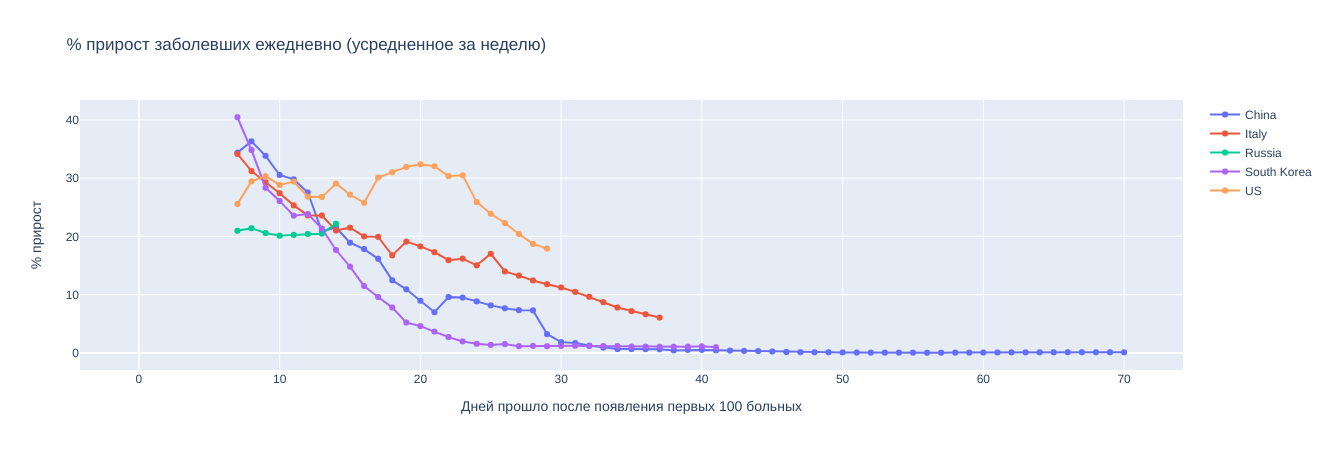

In [384]:
import plotly.graph_objects as go
fig = go.Figure()

cdf_result = {}

for country in include_plot:
    fig.add_trace(go.Scatter(x=roc_cdf_mean.index, y=roc_cdf_mean[country].values*100,
                    mode='lines+markers',
                    name=country))
    
fig.update_layout(
    title="% прирост заболевших ежедневно (усредненное за неделю)",
    yaxis_title="% прирост",
    xaxis_title="Дней прошло после появления первых 100 больных",
)

fig.show()

fig.write_html('covid_roc_since_100.html', include_plotlyjs='cdn')

In [392]:
2337*1.22**30

910864.1988365407